<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Baseline-model-+-weighted-classes" data-toc-modified-id="Baseline-model-+-weighted-classes-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Baseline model + weighted classes</a></span></li><li><span><a href="#Investigate-various-values-of-gamma-and-learning_rate" data-toc-modified-id="Investigate-various-values-of-gamma-and-learning_rate-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Investigate various values of <code>gamma</code> and <code>learning_rate</code></a></span></li><li><span><a href="#Grid-search-with-additional-hyperparameters" data-toc-modified-id="Grid-search-with-additional-hyperparameters-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Grid search with additional hyperparameters</a></span></li><li><span><a href="#New-parameters-+-more-investigation-of-max_depth" data-toc-modified-id="New-parameters-+-more-investigation-of-max_depth-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>New parameters + more investigation of <code>max_depth</code></a></span></li><li><span><a href="#More-investigation-of-max_depth-et-al." data-toc-modified-id="More-investigation-of-max_depth-et-al.-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>More investigation of <code>max_depth</code> et al.</a></span></li><li><span><a href="#Additional-investigation-of-gamma-and-reg_alpha" data-toc-modified-id="Additional-investigation-of-gamma-and-reg_alpha-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Additional investigation of <code>gamma</code> and <code>reg_alpha</code></a></span></li><li><span><a href="#Final-model" data-toc-modified-id="Final-model-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>Final model</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

# Introduction

The purpose of this project is to tune an XGBoost model to classify wines according to whether they are "high quality" or not. The data comes from the UCI wines dataset, and I have combined reds and whites, adding a feature to record the type of each wine. "High quality" wines are those with a rating of 7 or higher (this is a somewhat arbitrary cutoff). 

The final model achieves 87% accuracy on holdout data, with an F1 score of 0.92 for low-quality wines and 0.62 for high-quality wines. There is clearly still some work to be done to improve both precision and recall for high-quality wines.

# EDA

In [0]:
# Load needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

In [0]:
# Define a function to print selected model metrics
def print_metrics(y_true, y_pred):
    '''Print accuracy score, confusion matrix, and classification report.
    
    Keyword arguments:
    y_true: groud-truth labels
    y_pred: predicted labels
    
    Dependencies: 
    sklearn.metrics.accuracy_score
    sklearn.metrics.confusion_matrix
    sklearn.metrics.classification_report
    '''
    acc_score = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    print('Accuracy:', acc_score)
    print('-------')
    print('Confusion matrix:')
    print(conf_matrix)
    print('-------')
    print('Classification report:')
    print(class_report)

In [3]:
# Read in the data from a local source
# red = pd.read_csv('winequality-red.csv', sep=';')
# red.info()

# Connect to Google Drive if working in Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Read in red wines dataset from Drive
red = pd.read_csv('/content/drive/My Drive/xg-boozed/winequality-red.csv', sep=';')
red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


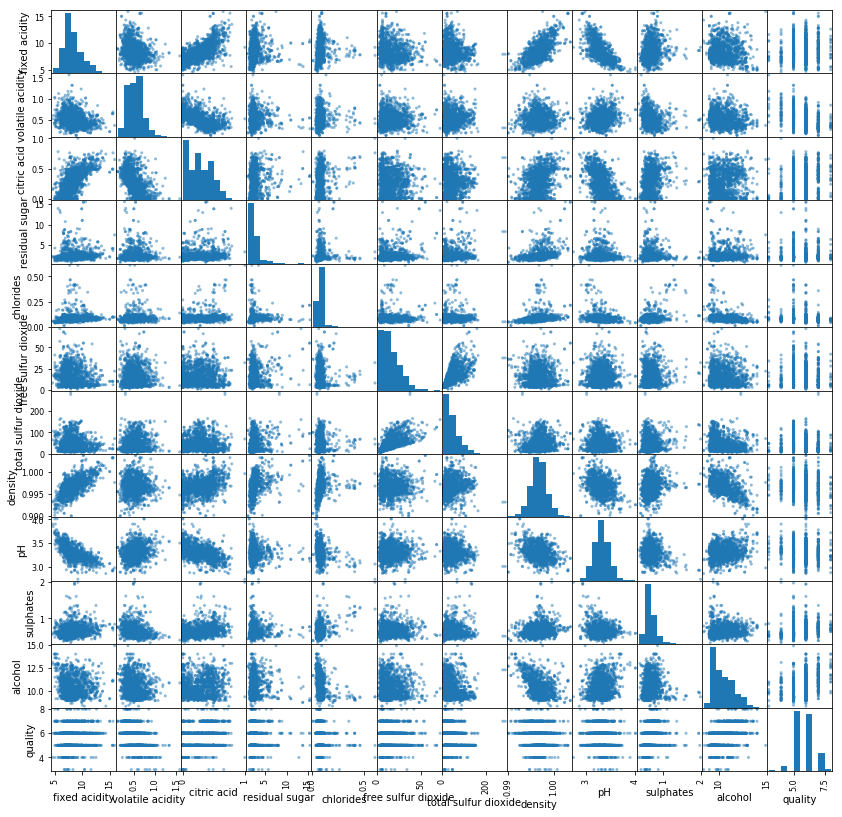

In [0]:
# Inspect distributions of red wine features
pd.plotting.scatter_matrix(red, figsize=(14,14));

In [0]:
# Inspect distribution of quality ratings
red['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [5]:
# Read in white wine dataset
white = pd.read_csv('/content/drive/My Drive/xg-boozed/winequality-white.csv', sep=';')
white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


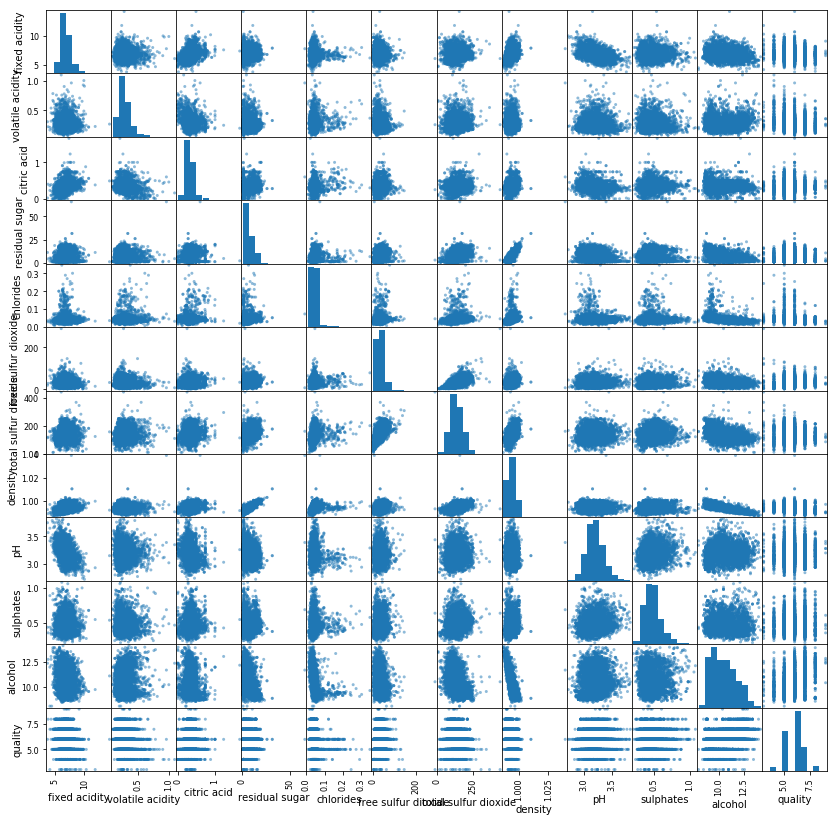

In [0]:
# Visualize distributions of white wine features
pd.plotting.scatter_matrix(white, figsize=(14,14));

In [0]:
# View distribution of quality ratings
white['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

# Feature engineering

In [0]:
# Create a new feature to record wine type
red['type'] = 1
white['type'] = 0

In [7]:
# Merge the two datasets
wines = pd.concat([red, white], axis=0)
wines = wines.sample(frac=1).reset_index(drop=True)
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
type                    6497 non-null int64
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [8]:
# Inspect some values
wines.head(20)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.2,0.250,0.37,2.50,0.063,11.0,41.0,0.99439,3.52,0.80,12.4,7,1
1,7.5,0.705,0.10,13.00,0.044,44.0,214.0,0.99741,3.10,0.50,9.1,5,0
2,7.8,0.530,0.04,1.70,0.076,17.0,31.0,0.99640,3.33,0.56,10.0,6,1
3,8.6,0.360,0.26,11.10,0.030,43.5,171.0,0.99480,3.03,0.49,12.0,5,0
4,6.3,0.200,0.26,4.70,0.040,108.0,168.0,0.99278,3.07,0.75,10.7,7,0
5,6.9,0.150,0.29,2.30,0.033,14.0,82.0,0.99132,3.10,0.58,11.2,7,0
6,7.8,0.520,0.25,1.90,0.081,14.0,38.0,0.99840,3.43,0.65,9.0,6,1
7,6.5,0.320,0.12,11.50,0.033,35.0,165.0,0.99740,3.22,0.32,9.0,5,0
8,7.8,0.580,0.13,2.10,0.102,17.0,36.0,0.99440,3.24,0.53,11.2,6,1
9,7.8,0.290,0.33,8.75,0.035,33.0,181.0,0.99620,3.11,0.46,10.7,5,0


In [9]:
# Check quality ratings distribution again
wines['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [11]:
# Count the "high quality" wines
print(len(wines[wines['quality']>=7]))
print(wines['quality'].describe())

1277
count    6497.000000
mean        5.818378
std         0.873255
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64


In [0]:
# Create the target variable
wines['high_quality'] = np.where(wines['quality'] >= 7, 1, 0)

In [13]:
# Edit feature names
wines.columns = [x.replace(' ', '_') for x in wines.columns]
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
fixed_acidity           6497 non-null float64
volatile_acidity        6497 non-null float64
citric_acid             6497 non-null float64
residual_sugar          6497 non-null float64
chlorides               6497 non-null float64
free_sulfur_dioxide     6497 non-null float64
total_sulfur_dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
type                    6497 non-null int64
high_quality            6497 non-null int64
dtypes: float64(11), int64(3)
memory usage: 710.7 KB


In [0]:
# Separate features and target
features = wines.drop(['quality', 'high_quality'], axis=1)
target = wines['high_quality']

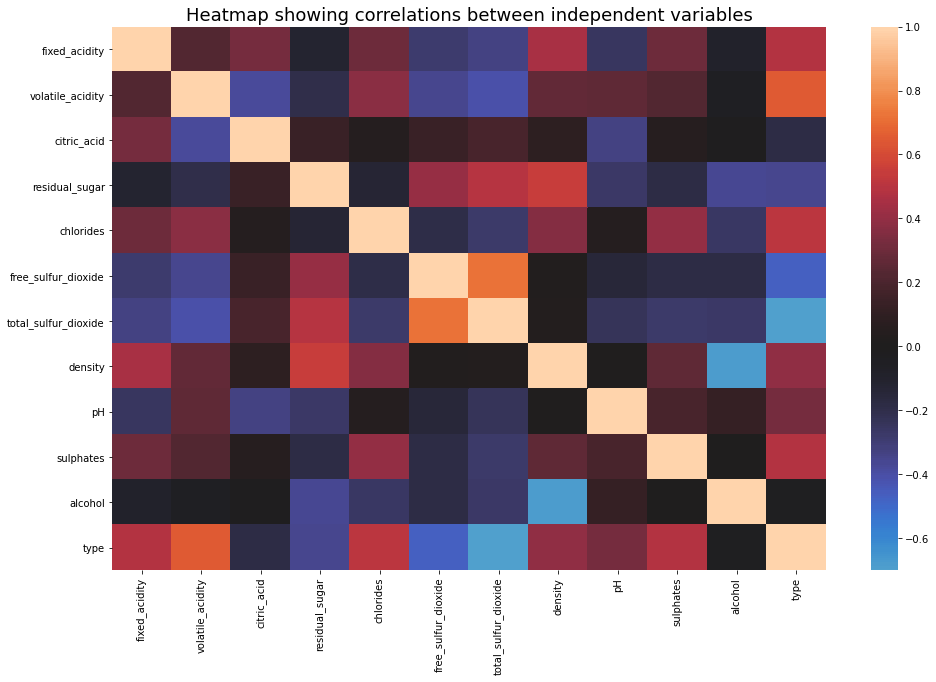

In [15]:
# Visualize correlations between features
corr = features.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr, center=0)
plt.title('Heatmap showing correlations between independent variables', 
          fontsize=18)
plt.show();

In [16]:
# Find splitting point for 80% train, 10% validation, 10% test
all_length = len(wines)
train_len = round(0.8 * all_length)
val_len = round(0.1 * all_length)

print('Train set length:', train_len)
print('Validation set length:', val_len)

Train set length: 5198
Validation set length: 650


In [0]:
# Create training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=val_len,
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=val_len,
                                                  random_state=1)

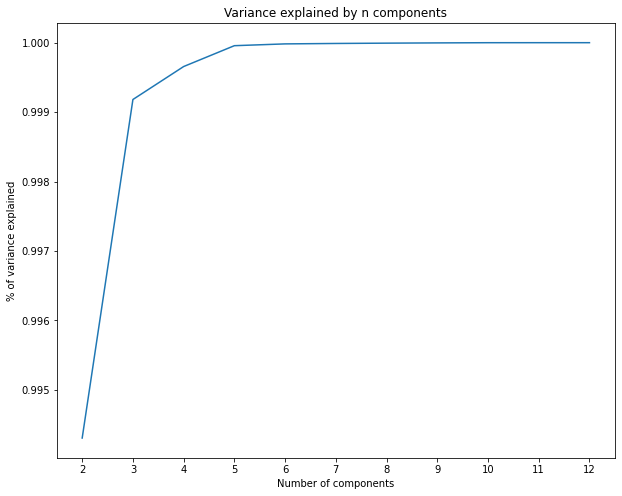

In [18]:
# Try several numbers of components to explain >=80% of variance
comps = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
var_sums = []
for comp in comps:
    pca = PCA(n_components=comp)
    pca.fit_transform(X_train)
    var_sums.append(np.sum(pca.explained_variance_ratio_))
    
# Visualize results
plt.figure(figsize=(10,8))
plt.plot(comps, var_sums)
plt.xlabel('Number of components')
plt.ylabel('% of variance explained')
plt.title('Variance explained by n components')
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.show();

In [0]:
# Decompose features for training, validation, and test sets
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)

X_val_pca = pca.transform(X_val)

X_test_pca = pca.transform(X_test)

# Modeling

## Baseline model

In [20]:
# Instantiate the classifier
xg = xgb.XGBClassifier(random_state=1)

xg.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:
# View metrics for the training data
y_pred = xg.predict(X_train_pca)

print_metrics(y_train, y_pred)

Accuracy: 0.8449105253030594
-------
Confusion matrix:
[[4029  133]
 [ 673  362]]
-------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4162
           1       0.73      0.35      0.47      1035

    accuracy                           0.84      5197
   macro avg       0.79      0.66      0.69      5197
weighted avg       0.83      0.84      0.82      5197



In [22]:
# View metrics for the validation data
y_pred = xg.predict(X_val_pca)

print_metrics(y_val, y_pred)

Accuracy: 0.8461538461538461
-------
Confusion matrix:
[[508  19]
 [ 81  42]]
-------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       527
           1       0.69      0.34      0.46       123

    accuracy                           0.85       650
   macro avg       0.78      0.65      0.68       650
weighted avg       0.83      0.85      0.82       650



## Baseline model + weighted classes

In [0]:
# Weight the two `high_quality` classes differently
weight = len(y_train[y_train == 1]) / len(y_train[y_train == 0])
weights_vector = np.where(y_train == 1, 1, weight)

In [24]:
# Instantiate a classifier with weighted classes
xg = xgb.XGBClassifier(sample_weight=weights_vector, random_state=1)

xg.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1,
              sample_weight=array([0.24867852, 0.24867852, 1.        , ..., 0.24867852, 0.24867852,
       1.        ]),
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbosity=1)

In [25]:
# View metrics for the training data
y_pred = xg.predict(X_train_pca)

print_metrics(y_train, y_pred)

Accuracy: 0.8449105253030594
-------
Confusion matrix:
[[4029  133]
 [ 673  362]]
-------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4162
           1       0.73      0.35      0.47      1035

    accuracy                           0.84      5197
   macro avg       0.79      0.66      0.69      5197
weighted avg       0.83      0.84      0.82      5197



## Investigate various values of `gamma` and `learning_rate`

In [26]:
# Use Grid Search to test various hyperparameters
params = {'gamma': [0.0, 0.1, 1, 10],
          'learning_rate': [0.1, 0.5, 0.8],
          'n_jobs': [-1],
          'random_state': [1]}

xg = xgb.XGBClassifier()
grid = GridSearchCV(xg, params, cv=3, n_jobs=-1)
grid.fit(X_train_pca, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0.0, 0.1, 1, 10],
                         'learning_rate': [0.1, 0.5, 0.8], 'n_jobs': [-1],
                         'random_state': [1]},
    

In [27]:
# View best score and parameters
print('Best score:', grid.best_score_)
print('Best params:', grid.best_params_)

Best score: 0.8402937232111167
Best params: {'gamma': 0.0, 'learning_rate': 0.5, 'n_jobs': -1, 'random_state': 1}


In [28]:
# Fit a model with best params plus weighted classes
xg = xgb.XGBClassifier(gamma=1, learning_rate=0.5, sample_weight=weights_vector, n_jobs=-1, random_state=1)
xg.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1,
              sample_weight=array([0.24867852, 0.24867852, 1.        , ..., 0.24867852, 0.24867852,
       1.        ]),
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbosity=1)

In [29]:
# View metrics for training data
y_pred = xg.predict(X_train_pca)
print_metrics(y_train, y_pred)

Accuracy: 0.9112949778718491
-------
Confusion matrix:
[[4074   88]
 [ 373  662]]
-------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4162
           1       0.88      0.64      0.74      1035

    accuracy                           0.91      5197
   macro avg       0.90      0.81      0.84      5197
weighted avg       0.91      0.91      0.91      5197



In [30]:
# View metrics for validation data
y_pred = xg.predict(X_val_pca)
print_metrics(y_val, y_pred)

Accuracy: 0.8446153846153847
-------
Confusion matrix:
[[491  36]
 [ 65  58]]
-------
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       527
           1       0.62      0.47      0.53       123

    accuracy                           0.84       650
   macro avg       0.75      0.70      0.72       650
weighted avg       0.83      0.84      0.84       650



## Grid search with additional hyperparameters

In [31]:
# Try a new set of hyperparameters
eval_set = [(X_train_pca, y_train), (X_val_pca, y_val)]
eval_metric = ["auc","error"]

xg = xgb.XGBClassifier(scale_pos_weight=1,
                       learning_rate=0.01,  
                       colsample_bytree=0.4,
                       subsample=0.8,
                       objective='binary:logistic', 
                       n_estimators=1000, 
                       reg_alpha=0.3,
                       max_depth=4, 
                       gamma=10,
                       random_state=1)
xg.fit(X_train_pca, y_train, eval_metric=eval_metric, eval_set=eval_set)

[0]	validation_0-auc:0.640588	validation_0-error:0.199153	validation_1-auc:0.66082	validation_1-error:0.189231
[1]	validation_0-auc:0.650987	validation_0-error:0.199153	validation_1-auc:0.678916	validation_1-error:0.189231
[2]	validation_0-auc:0.714382	validation_0-error:0.199153	validation_1-auc:0.722474	validation_1-error:0.189231
[3]	validation_0-auc:0.722909	validation_0-error:0.199153	validation_1-auc:0.731314	validation_1-error:0.189231
[4]	validation_0-auc:0.769827	validation_0-error:0.199153	validation_1-auc:0.794388	validation_1-error:0.189231
[5]	validation_0-auc:0.788636	validation_0-error:0.198769	validation_1-auc:0.810231	validation_1-error:0.189231
[6]	validation_0-auc:0.794717	validation_0-error:0.196844	validation_1-auc:0.802703	validation_1-error:0.189231
[7]	validation_0-auc:0.792422	validation_0-error:0.194535	validation_1-auc:0.795892	validation_1-error:0.189231
[8]	validation_0-auc:0.789123	validation_0-error:0.196844	validation_1-auc:0.793354	validation_1-error:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

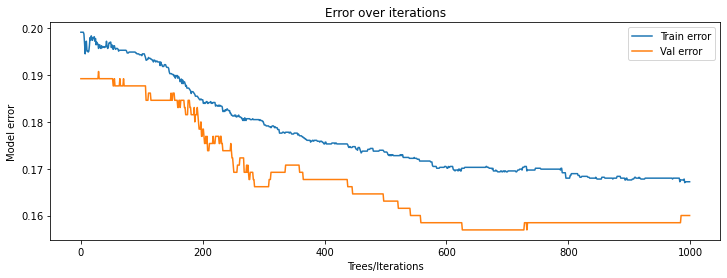

In [33]:
# Visualize training and validation error over iterations
train_err = xg.evals_result()['validation_0']['error']
val_err = xg.evals_result()['validation_1']['error']
x = [i for i in range(0, 1000)]
plt.figure(figsize=(12,4))
plt.plot(x, train_err, label='Train error')
plt.plot(x, val_err, label='Val error')
plt.xlabel('Trees/Iterations')
plt.ylabel('Model error')
plt.title('Error over iterations')
plt.legend()
plt.show();

## New parameters + more investigation of `max_depth`

In [34]:
# Use Grid Search to investigate max_depth
params = {'n_estimators': [550],
          'random_state': [1],
          'scale_pos_weight': [1],
          'max_depth': [3, 6, 7, 8, 9],
          'gamma': [10],
          'learning_rate': [0.01],
          'colsample_bytree': [0.4],
          'subsample': [0.8],
          'objective': ['binary:logistic'],
          'reg_alpha': [0.3],}

xg = xgb.XGBClassifier()

grid = GridSearchCV(xg, params, cv=3)
grid.fit(X_train_pca, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.4], 'gamma': [10],
                         'learning_rate': [0.01], 'max_depth': [3, 6, 7, 8, 9],
                         'n_estimators': [550],
              

In [35]:
# View best score and parameters
print('Best score:', grid.best_score_)
print('Best params:', grid.best_params_)

Best score: 0.8220139820812938
Best params: {'colsample_bytree': 0.4, 'gamma': 10, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 550, 'objective': 'binary:logistic', 'random_state': 1, 'reg_alpha': 0.3, 'scale_pos_weight': 1, 'subsample': 0.8}


## More investigation of `max_depth` et al.

In [36]:
# Use Grid Search to investigate several hyperparameters
params = {'n_estimators': [550],
          'random_state': [1],
          'scale_pos_weight': [1],
          'max_depth': [7, 8, 9],
          'gamma': [0, 1, 5],
          'learning_rate': [0.1, 0.01],
          'colsample_bytree': [0.8, 0.9, 1.0],
          'subsample': [0.8, 0.9, 1.0],
          'objective': ['binary:logistic'],
          'reg_alpha': [0.3]}

xg = xgb.XGBClassifier()

grid = GridSearchCV(xg, params, cv=3)
grid.fit(X_train_pca, y_train)

# View best score and parameters
print('Best score:', grid.best_score_)
print('Best params:', grid.best_params_)

Best score: 0.8543406597555846
Best params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 550, 'objective': 'binary:logistic', 'random_state': 1, 'reg_alpha': 0.3, 'scale_pos_weight': 1, 'subsample': 0.9}


In [37]:
# View metrics for validation set
y_pred = grid.predict(X_val_pca)
print_metrics(y_val, y_pred)

Accuracy: 0.86
-------
Confusion matrix:
[[492  35]
 [ 56  67]]
-------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       527
           1       0.66      0.54      0.60       123

    accuracy                           0.86       650
   macro avg       0.78      0.74      0.76       650
weighted avg       0.85      0.86      0.85       650



In [38]:
# Fit current best model
xg = xgb.XGBClassifier(scale_pos_weight=1,
                       learning_rate=0.1,  
                       colsample_bytree = 1.0,
                       subsample = 1.0,
                       objective='binary:logistic', 
                       n_estimators=1000, 
                       reg_alpha = 0.3,
                       max_depth=7, 
                       gamma=0,
                       random_state=1)
xg.fit(X_train_pca, y_train, eval_metric=eval_metric, eval_set=eval_set)

[0]	validation_0-auc:0.848705	validation_0-error:0.141428	validation_1-auc:0.794542	validation_1-error:0.163077
[1]	validation_0-auc:0.867844	validation_0-error:0.135655	validation_1-auc:0.810108	validation_1-error:0.166154
[2]	validation_0-auc:0.87211	validation_0-error:0.135463	validation_1-auc:0.822457	validation_1-error:0.164615
[3]	validation_0-auc:0.87561	validation_0-error:0.133923	validation_1-auc:0.822604	validation_1-error:0.166154
[4]	validation_0-auc:0.883286	validation_0-error:0.12969	validation_1-auc:0.828188	validation_1-error:0.156923
[5]	validation_0-auc:0.891304	validation_0-error:0.130075	validation_1-auc:0.827301	validation_1-error:0.167692
[6]	validation_0-auc:0.902599	validation_0-error:0.122956	validation_1-auc:0.825597	validation_1-error:0.158462
[7]	validation_0-auc:0.905262	validation_0-error:0.122763	validation_1-auc:0.824733	validation_1-error:0.16
[8]	validation_0-auc:0.90964	validation_0-error:0.11853	validation_1-auc:0.828258	validation_1-error:0.161538
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1)

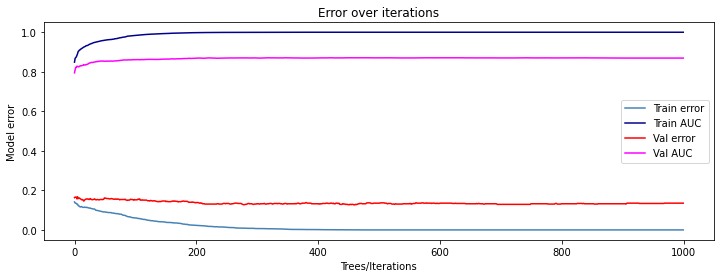

In [39]:
# Visualize training and validation error and AUC
train_err = xg.evals_result()['validation_0']['error']
train_auc = xg.evals_result()['validation_0']['auc']
val_err = xg.evals_result()['validation_1']['error']
val_auc = xg.evals_result()['validation_1']['auc']

x = [i for i in range(0, 1000)]
plt.figure(figsize=(12,4))
plt.plot(x, train_err, label='Train error', color='steelblue')
plt.plot(x, train_auc, label='Train AUC', color='darkblue')
plt.plot(x, val_err, label='Val error', color='red')
plt.plot(x, val_auc, label='Val AUC', color='magenta')
plt.xlabel('Trees/Iterations')
plt.ylabel('Model error')
plt.title('Error over iterations')
plt.legend()
plt.show();

## Additional investigation of `gamma` and `reg_alpha`

In [40]:
# Investigate various values of reg_alpha and gamma
params = {'n_estimators': [500],
          'random_state': [1],
          'sample_weight': [weights_vector],
          'max_depth': [7],
          'gamma': [0, 0.1, 1],
          'learning_rate': [0.1],
          'colsample_bytree': [1.0],
          'subsample': [1.0],
          'objective': ['binary:logistic'],
          'reg_alpha': [0, 0.1, 0.3, 0.5],}

xg = xgb.XGBClassifier()

grid = GridSearchCV(xg, params, cv=3)
grid.fit(X_train_pca, y_train)

# View best score and parameters
print('Best score:', grid.best_score_)
print('Best params:', grid.best_params_)

Best score: 0.8522239798291286
Best params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 1, 'reg_alpha': 0.1, 'sample_weight': array([0.24867852, 0.24867852, 1.        , ..., 0.24867852, 0.24867852,
       1.        ]), 'subsample': 1.0}


In [41]:
# View metrics for training set
y_pred = grid.predict(X_train_pca)
print_metrics(y_train, y_pred)

Accuracy: 0.9998075812969021
-------
Confusion matrix:
[[4162    0]
 [   1 1034]]
-------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4162
           1       1.00      1.00      1.00      1035

    accuracy                           1.00      5197
   macro avg       1.00      1.00      1.00      5197
weighted avg       1.00      1.00      1.00      5197



In [42]:
# View metrics for validation set
y_pred = grid.predict(X_val_pca)
print_metrics(y_val, y_pred)

Accuracy: 0.8646153846153846
-------
Confusion matrix:
[[494  33]
 [ 55  68]]
-------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       527
           1       0.67      0.55      0.61       123

    accuracy                           0.86       650
   macro avg       0.79      0.75      0.76       650
weighted avg       0.86      0.86      0.86       650



## Final model

In [43]:
# Fit final model
xg = xgb.XGBClassifier(n_estimators=500,
                       gamma=0,
                       sample_weight=weights_vector,
                       reg_alpha=0.3,
                       max_depth=7,
                       random_state=1
                       )
xg.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0.3, reg_lambda=1,
              sample_weight=array([0.24867852, 0.24867852, 1.        , ..., 0.24867852, 0.24867852,
       1.        ]),
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbosity=1)

In [44]:
# View metrics for validation data
y_train_pred = xg.predict(X_train_pca)
print_metrics(y_train, y_train_pred)

Accuracy: 1.0
-------
Confusion matrix:
[[4162    0]
 [   0 1035]]
-------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4162
           1       1.00      1.00      1.00      1035

    accuracy                           1.00      5197
   macro avg       1.00      1.00      1.00      5197
weighted avg       1.00      1.00      1.00      5197



In [45]:
# View metrics for validation data
y_val_pred = xg.predict(X_val_pca)
print_metrics(y_val, y_val_pred)

Accuracy: 0.8646153846153846
-------
Confusion matrix:
[[494  33]
 [ 55  68]]
-------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       527
           1       0.67      0.55      0.61       123

    accuracy                           0.86       650
   macro avg       0.79      0.75      0.76       650
weighted avg       0.86      0.86      0.86       650



In [46]:
# View metrics for test data
y_test_pred = xg.predict(X_test_pca)
print_metrics(y_test, y_test_pred)

Accuracy: 0.8723076923076923
-------
Confusion matrix:
[[494  37]
 [ 46  73]]
-------
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       531
           1       0.66      0.61      0.64       119

    accuracy                           0.87       650
   macro avg       0.79      0.77      0.78       650
weighted avg       0.87      0.87      0.87       650



In [0]:
# Summary

The best model uses 500 trees with a maximum depth of 7, some regularization, and weighting of the target classes. All other hyperparameters were left with default values. The final model achieves 99.9% accuracy on training data and 87.2% accuracy on validation and test data. F1 score is much lower for high-quality wines, despite weighting of the classes. 